In [1]:
import sys
import os
from pathlib import Path

root_path = Path(os.getcwd()).parent
sys.path.append(str(root_path))

In [2]:
import json
from datetime import datetime

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from icecream import ic
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm


from src import GRID_SIZE, CELL_SIZE, SGF_PATH, IMG_PATH, SCREEN_SIZE
from src.stone_classification import StoneClassifactionModel
from src.utils.game import Game
from src.utils.cv2_helper import blur_and_sharpen


In [3]:
img_path = IMG_PATH.joinpath("sgf")

In [4]:
with open(root_path.joinpath("data", "corners.json"), "r") as f:
    data = json.load(f)

In [5]:
games = {}
for i in data.keys():
    game = Game()
    game.add_sgf(SGF_PATH.joinpath(f"{i}.sgf"))
    games[i] = game

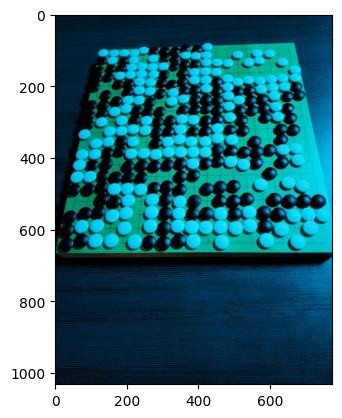

In [6]:
img = cv2.imread(str(img_path.joinpath("1", "1_jwerth_cyan_2.jpg")))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# CNN

In [7]:
TRAIN_PERCENTAGE = 0.7
BATCH_SIZE = 128
LEARNING_RATE = 0.001
EPOCHS = 2

In [8]:
def transform_image(img: np.ndarray, corners: list[list[float]]) -> np.ndarray:
    matrix = cv2.getPerspectiveTransform(
        np.float32(
            [[int(c[0] * img.shape[1]), int(c[1] * img.shape[0])] for c in corners]
        ),
        np.float32(
            [
                [0, 0],
                [SCREEN_SIZE, 0],
                [SCREEN_SIZE, SCREEN_SIZE],
                [0, SCREEN_SIZE],
            ]
        ),
    )
    return cv2.warpPerspective(img, matrix, (SCREEN_SIZE, SCREEN_SIZE))


def extract_cells(frame) -> list:
    cell_size = SCREEN_SIZE // GRID_SIZE
    half_size = cell_size // 2

    return [
        [
            cv2.resize(
                blur_and_sharpen(
                    frame[
                        max(0, y * cell_size - half_size) : min(
                            frame.shape[0], (y + 1) * cell_size + half_size
                        ),
                        max(0, x * cell_size - half_size) : min(
                            frame.shape[1], (x + 1) * cell_size + half_size
                        ),
                    ]
                ),
                (CELL_SIZE, CELL_SIZE),
            )
            for x in range(GRID_SIZE)
        ]
        for y in range(GRID_SIZE)
    ]


In [9]:
label_data = []
count = 0
for key, images in tqdm(data.items()):
    for filename, corners in images.items():
        count += 1
        image = cv2.imread(str(img_path.joinpath(key, filename)))
        transformed_img = transform_image(image, corners)
        cell_images = extract_cells(transformed_img)

        # (class, image)
        label_data += [
            (games[key].board[y][x].value, cell_images[y][x])
            for x in range(GRID_SIZE)
            for y in range(GRID_SIZE)
        ]

100%|██████████| 11/11 [00:03<00:00,  3.47it/s]


In [10]:
print(len(label_data))

27797


1


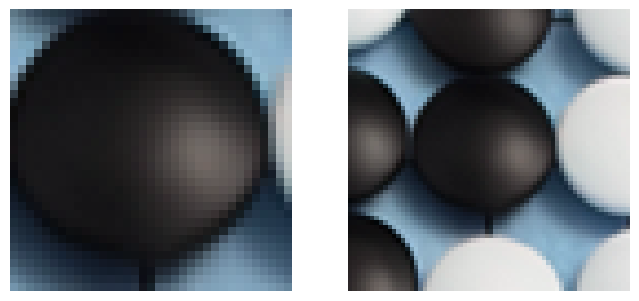

In [26]:
i = 40
print(label_data[i][0])

fig, axes = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={"wspace": 0.2})

# Display the images
axes[1].imshow(label_data[i][1])
axes[1].axis("off")  # Hide axes

axes[0].imshow(label_data[i][1][15:50, 15:50, :])
axes[0].axis("off")  # Hide axes

# Show the figure
plt.show()

In [75]:
df_labels = pd.DataFrame(label_data)
df_labels[0].value_counts()

0
0    10667
1     8623
2     8507
Name: count, dtype: int64

In [76]:
# Randomize
df_labels = df_labels.sample(frac=1, random_state=10).reset_index(drop=True)
df_labels[0].value_counts()

0
0    10667
1     8623
2     8507
Name: count, dtype: int64

### Undersample

In [78]:
column_name = df_labels.columns[0]

# Count the number of samples in each category
min_count = df_labels[column_name].value_counts().min()

# Create a list to hold the undersampled DataFrame
undersampled_df = pd.DataFrame()

# Loop through each category and sample
for label in df_labels[column_name].unique():
    undersampled_df = pd.concat(
        [
            undersampled_df,
            df_labels[df_labels[column_name] == label].sample(
                min_count, random_state=42
            ),
        ]
    )

df_labels = undersampled_df.sample(frac=1, random_state=42).reset_index(drop=True)
df_labels[0].value_counts()

0
1    8507
2    8507
0    8507
Name: count, dtype: int64

In [82]:
total_labels = df_labels.shape[0]
ic(total_labels)
amount_train_labels = int(total_labels * TRAIN_PERCENTAGE)

train_labels, test_labels = (
    df_labels[:amount_train_labels],
    df_labels[amount_train_labels:],
)
ic(len(train_labels))
ic(len(test_labels))


ic| total_labels: 25521
ic| len(train_labels): 17864
ic| len(test_labels): 7657


7657

### Creating a Dataset

In [94]:
class StonesDataset(Dataset):
    def __init__(self, labels: pd.DataFrame, transform=None):
        self.labels = labels
        self.transform = transform

    def __len__(self) -> int:
        return self.labels.shape[0]

    def __getitem__(self, idx):
        label, image = self.labels.iloc[idx]
        tensor = torch.from_numpy(image)
        tensor = tensor.permute(2, 0, 1)
        if self.transform:
            tensor = self.transform(tensor)
        label = int(label)

        return tensor, label


transform = transforms.Compose(
    [
        transforms.ToPILImage(),  # ! has to be here otherwise you won't be able to display them later
        # transforms.RandomCrop(),
        # transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
        transforms.Resize((CELL_SIZE, CELL_SIZE)),  # Resize to 105x105
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize
    ]
)
train_dataset = StonesDataset(train_labels, transform)
test_dataset = StonesDataset(test_labels, transform)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=True)

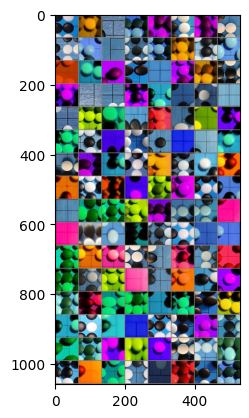

In [85]:
def show(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, label_tuples = next(dataiter)

# show images
show(torchvision.utils.make_grid(images))

### Neural Network

In [89]:
net = StoneClassifactionModel()

### Optimizer

In [90]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [92]:
batches_count = 0
for epoch in tqdm(range(EPOCHS)):
    running_loss = 0
    for i, data in enumerate(train_loader, 0):
        inputs, label_tuples = data

        optimizer.zero_grad()
        outputs = net(inputs)

        loss = criterion(outputs, label_tuples)
        running_loss += loss
        loss.backward()
        optimizer.step()
print("Finished Training")

100%|██████████| 2/2 [00:28<00:00, 14.21s/it]

Finished Training


### Save NN

In [ ]:
PATH = (
    f"../weights/{datetime.now().strftime('%y%m%d%H%M%S')}-classification_weights.pth"
)
torch.save(net.state_dict(), PATH)

In [ ]:
net = StoneClassifactionModel()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [95]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, label_tuples = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += label_tuples.size(0)
        correct += (predicted == label_tuples).sum().item()
print(
    f"Accuracy of the network on the {total} test images: {100 * correct / total:.2f} %"
)


Accuracy of the network on the 7657 test images: 98.85 %


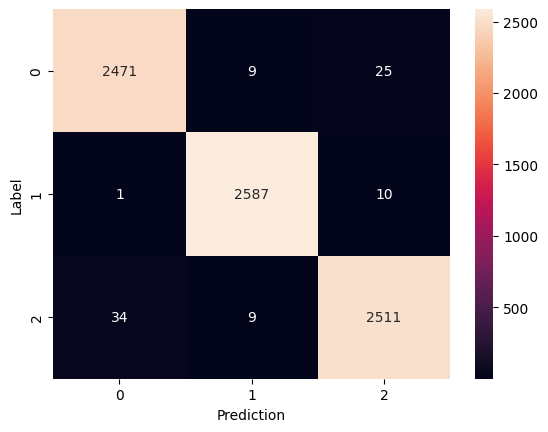

In [ ]:
results = []
wrong_images = []

with torch.no_grad():
    for data in test_loader:
        images, label_tuples = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction, image in zip(label_tuples, predictions, images):
            results += [(int(label), int(prediction))]
            if prediction != label:
                wrong_images.append(image)

df = pd.DataFrame(results, columns=["Label", "Prediction"])

heatmap_data = df.pivot_table(
    index="Label", columns="Prediction", aggfunc="size", fill_value=0
)
sns.heatmap(heatmap_data, annot=True, fmt="d")
plt.show()

In [120]:
df.value_counts()

Label  Prediction
1      1             2587
2      2             2511
0      0             2471
2      0               34
0      2               25
1      2               10
0      1                9
2      1                9
1      0                1
Name: count, dtype: int64

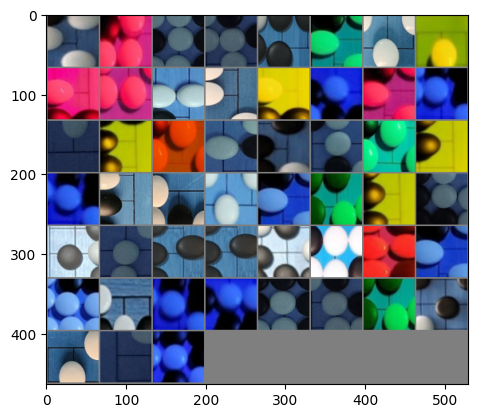

In [75]:
show(torchvision.utils.make_grid(wrong_images))

# 3. Random Forest

In [111]:
labels = df_labels[0].values.tolist()
images = df_labels[1].values.tolist()

In [112]:
X = np.array([img.flatten() for img in images])
y = np.array(labels)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

17864

In [114]:
clf = RandomForestClassifier(n_estimators=100, random_state=42, verbose=False)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9932088285229203
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2509
           1       1.00      1.00      1.00      2578
           2       0.99      0.99      0.99      2570

    accuracy                           0.99      7657
   macro avg       0.99      0.99      0.99      7657
weighted avg       0.99      0.99      0.99      7657



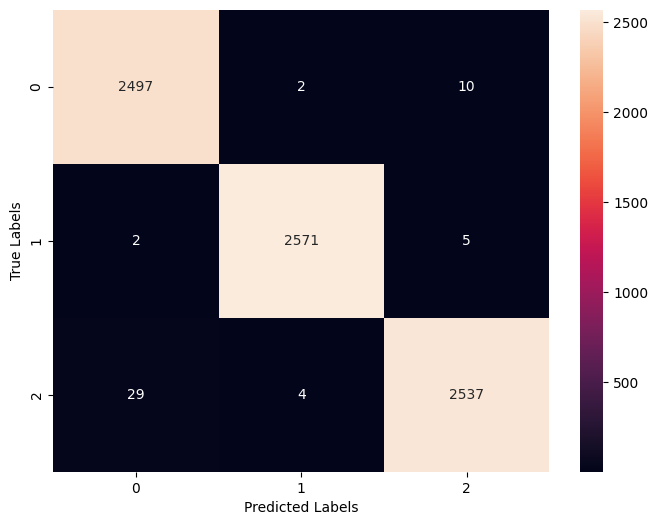

In [115]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix using sns.heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [116]:
len(y_test)

7657

In [16]:
import pickle

# Save the trained model to a file
with open("random_forest_model.pkl", "wb") as file:
    pickle.dump(clf, file)